In [68]:
import quandl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [69]:
df = quandl.get("HKEX/02383")

In [70]:
df.tail()

,Nominal Price,Net Change,Change (%),Bid,Ask,P/E(x),High,Low,Previous Close,Share Volume (000),Turnover (000),Lot Size
Date,,,,,,,,,,,,
2020-06-09,1.17,NaN,NaN,1.17,1.18,None,1.18,1.16,1.17,186.0,216.0,NaN
2020-06-10,1.16,NaN,NaN,1.15,1.17,None,1.16,1.11,1.17,208.0,239.0,NaN
2020-06-11,1.17,NaN,NaN,1.17,1.18,None,1.18,1.14,1.16,89.0,105.0,NaN
2020-06-12,1.17,NaN,NaN,1.15,1.18,None,1.17,1.17,1.17,20.0,23.0,NaN
2020-06-15,1.17,NaN,NaN,1.15,1.17,None,1.17,1.15,1.17,138.0,159.0,NaN


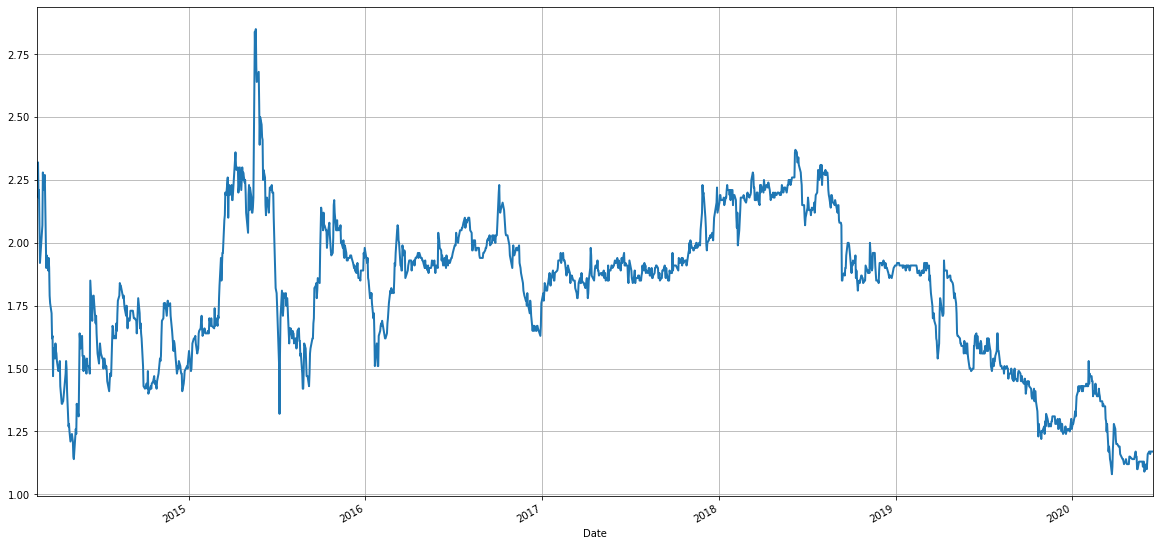

In [71]:
df['Nominal Price'].plot(grid = True, figsize = (20, 10), lw = 2)
plt.show()

# Trading Signals

In [72]:
short_window = 40
long_window = 100

signals = pd.DataFrame(index = df.index)
signals['signal'] = 0.0

signals['short_mavg'] = df['Nominal Price'].rolling(window = short_window, min_periods = 1, center = False).mean()
signals['long_mavg'] = df['Nominal Price'].rolling(window = long_window, min_periods = 1, center = False).mean()
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()
display(signals)

,signal,short_mavg,long_mavg,positions
Date,,,,
2014-02-21,0.0,2.25000,2.2500,NaN
2014-02-24,0.0,2.28500,2.2850,0.0
2014-02-25,0.0,2.25000,2.2500,0.0
2014-02-26,0.0,2.24000,2.2400,0.0
2014-02-27,0.0,2.20200,2.2020,0.0
...,...,...,...,...
2020-06-09,0.0,1.13300,1.2554,0.0
2020-06-10,0.0,1.13300,1.2527,0.0
2020-06-11,0.0,1.13375,1.2503,0.0


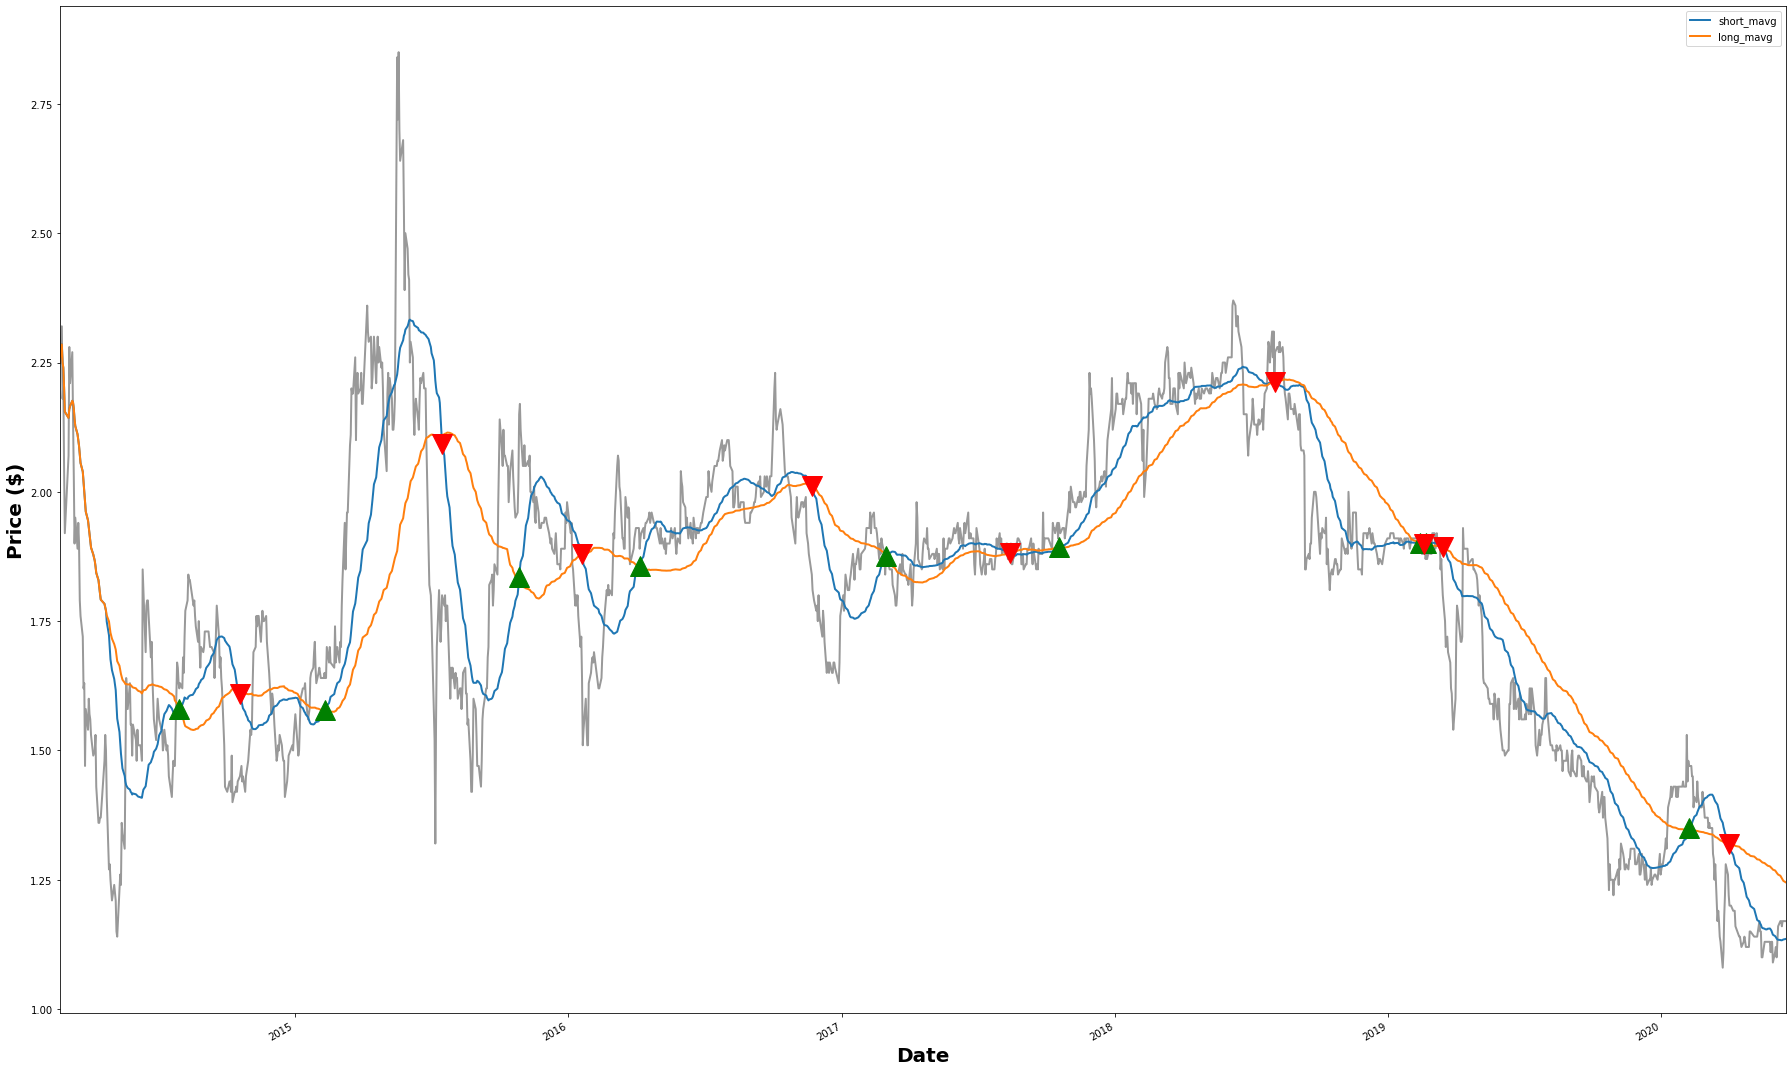

In [73]:
fig = plt.figure(figsize = (25,15))
ax1 = fig.add_subplot(111, ylabel = 'Price ($)')
df['Nominal Price'].plot(ax=ax1, color = 'black', lw = 2., alpha = 0.4)
signals[['short_mavg', 'long_mavg']].plot(ax = ax1, lw = 2.)
ax1.plot(signals.loc[signals.positions == 1.0].index, signals.short_mavg[signals.positions == 1.0], '^', markersize = 20, color = 'g')
ax1.plot(signals.loc[signals.positions == -1.0].index, signals.short_mavg[signals.positions == -1.0], 'v', markersize = 20, color = 'r')
plt.ylabel('Price ($)', fontweight = 'bold', fontsize = 20)
plt.xlabel('Date', fontweight = 'bold', fontsize = 20)
plt.tight_layout()

# Backtesting`

In [105]:
inital_capital = float(100000)
positions = pd.DataFrame(index = signals.index).fillna(0.0)
positions['Position in HKD'] = 1000*signals['signal']
portfolio = positions.multiply(df['Nominal Price'], axis = 0)
pos_diff = positions.diff()
portfolio['holdings'] = (positions.multiply(df['Nominal Price'], axis = 0)).sum(axis = 1)
portfolio['cash'] = initial_capital - (pos_diff.multiply(df['Nominal Price'], axis = 0)).sum(axis = 1).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()
del portfolio['Position in HKD']

In [106]:
portfolio

,holdings,cash,total,returns
Date,,,,
2014-02-21,0.0,100000.0,100000.0,NaN
2014-02-24,0.0,100000.0,100000.0,0.0
2014-02-25,0.0,100000.0,100000.0,0.0
2014-02-26,0.0,100000.0,100000.0,0.0
2014-02-27,0.0,100000.0,100000.0,0.0
...,...,...,...,...
2020-06-09,0.0,99370.0,99370.0,0.0
2020-06-10,0.0,99370.0,99370.0,0.0
2020-06-11,0.0,99370.0,99370.0,0.0


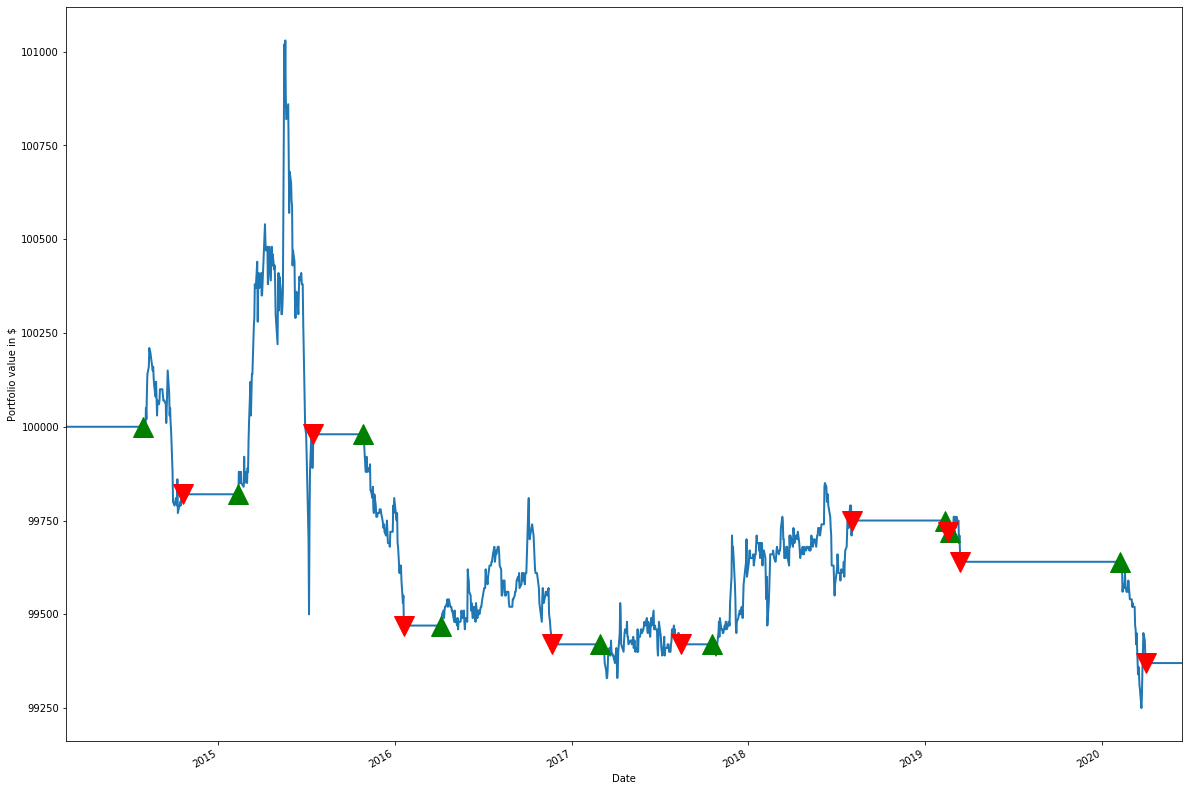

In [109]:
fig = plt.figure(figsize = (20,15))
ax1 = fig.add_subplot(111,ylabel = 'Portfolio value in $')
portfolio.total.plot(ax = ax1, lw = 2.)
ax1.plot(portfolio.loc[signals.positions == 1.0].index, portfolio.total[signals.positions == 1.0], '^', markersize = 20, color = 'g')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, portfolio.total[signals.positions == -1.0], 'v', markersize = 20, color = 'r')
plt.show()

In [112]:
print("Portfolio Total Value as of June 15, 2020")
print(portfolio['total'].tail(1))
print("Absolute return as of June 15, 2020")
print(((portfolio.total.tail(1)/float(100000))-float(1))*100)

Portfolio Total Value as of June 15, 2020
Date
2020-06-15    99370.0
Name: total, dtype: float64
Absolute return as of June 15, 2020
Date
2020-06-15   -0.63
Name: total, dtype: float64
